<a href="https://colab.research.google.com/github/Jaewon45/ESAA_2022/blob/main/0926_Ensemble_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7. 앙상블 학습과 랜덤 포레스트
- 앙상블 학습 : 일련의 예측기(앙상블)로부터 예측을 수집해 가장 좋은 모델 하나보다 더 좋은 예측 도출 
- 랜덤 포레스트 : 훈련세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기를 훈련시킴. 모든 개별 트리의 예측을 구해 가장 많은 선택을 받은 클래스를 예측으로 삼음
  - 넷플릭스 대회 참고 http://www.shalomeir.com/2014/11/netflix-prize-1/


## 7.1 투표 기반 분류기
1. 직접 투표 분류기 (hard voting) : 각 분류기의 예측을 모아 가장 많이 선택된 클래스 예측 
 - 개별 분류기보다 약한 학습기가 다양하게 모인 앙상블이 정확도가 높은 경우가 많음
 - 큰 수의 법칙 law of large numbers
 - 앙상블 방법은 예측기가 서로 독립적일때 최고의 성능을 냄
 - 다양한 분류기를 얻는 한가지 방법 : 다른 알고리즘으로 학습시키기



In [9]:
# dataset loading & splitting
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
# 투표기반분류기 (VotingClassifier) 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [11]:
# accuracy
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.852
RandomForestClassifier 0.904
SVC 0.916
VotingClassifier 0.912


- 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음
2. 간접 투표(soft voting) : 모든 분류기가 클래스의 확률을 예측할 수 있으면 (predict_proba() 메서드 존재) 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측
  - voting="hard"를 voting="soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨
  - SVC는 기본값에서 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 함 (단, 클래스 확률을 추정하기 위해 교차검증을 사용하므로 훈련 속도가 느려짐)


## 7.2 배깅과 페이스팅
- 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킴
  1. 배깅 (bagging) : 훈련세트에서 중복을 허용하여 샘플링하는 방식, bootsrap aggregating
  2. 페이스팅 (pasting) : 중복을 허용하지 않음
- 모든 예측기가 훈련을 마치면 예측을 모아서 새로운 샘플에 대한 예측을 도출
- 동시에 다른 CPU 코어나 서버에서 병렬로 학습 및 예측을 수행할 수 있기 때문에 인기가 높음
- 수집 함수 
  - 1) **분류**일 때 통계적 최빈값(statistical mode)
  - 2) **회귀**일 때 평균
- 개별 예측기는 원본 훈련세트로 훈련시킨 것보다 훨씬 크게 편향되어있지만 수집 함수를 통과하면 편향과 분산이 모두 감소
  - 일반적인 앙상블의 결과 : 원본 데이터셋으로 하나의 예측기를 훈련시킬떄와 비교해 편향은 비슷하지만 분산은 줄어듦


### 7.2.1 사이킷런의 배깅과 페이스팅

In [12]:
# DT 분류기 500개의 앙상블 훈련 (배깅)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1) 
# bootstrap=False 지정시 페이스팅
# n_jobs=-1 지정시 가용한 모든 코어 사용
# n_estimator : 분류기 개수
# BaggingClassifier는 기반 분류기가 클래스 확률을 추정할 수 있을 때 자동으로 간접 투표 방식 사용

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

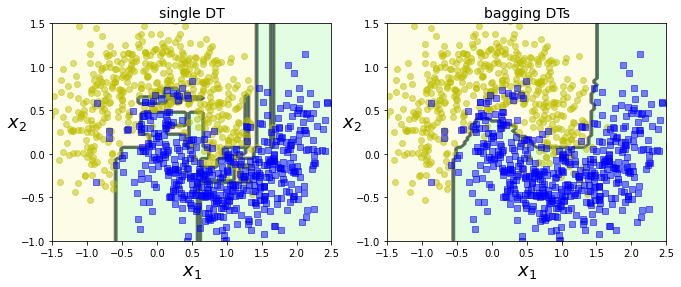

In [13]:
# 단일 DT와 앙상블의 결정경계 비교
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

# 단일 DT 모델 정의
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("single DT", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("bagging DTs", fontsize=14)
plt.show()

- 단일트리 결정경계와 500개의 트리를 사용한 배깅 앙상블의 결정경계 비교시 앙상블 예측이 결정트리 하나의 예측보다 일반화가 훨씬 잘됨
- 비슷한 편향에서 더 작은 분산을 만듦 (훈련세트의 오차수가 거의 비슷하지만 결정 결계가 덜 불규칙함)

 ### 7.2.2 oob 평가
- 배깅 사용시 어떤 샘플은 한 예측기를 위해 여러번 샘플링되지만 어떤 것은 전혀 샘플링되지 않을 수 있음
- BaggingClassifier는 기본값으로 중복을 허용, 훈련 세트의 크기만큼인 m개 샘플을 선택
 - m이 커지면 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링됨
 - 선택되지 않은 훈련샘플의 나머지 37%를 oob(out-of-bag) 샘플이라고 부름
 - 예측기마다 남겨진 37%는 모두 다름

- 예측기가 훈련되는 동안에는 oob샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 obb 샘플을 사용해 평가 가능
  - 앙상블의 평가는 각 예측기의 oob평가를 평균해 도출

- 사이킷런 BaggingClassifier에서 oob_score=True 지정시 훈련이 끝난 후 자동으로 obb평가 수행
  - 평가 점수 결과는 oob_score_ 변수에 저장

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [15]:
# 테스트세트 성능과 비교 -> 비슷함?
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [16]:
# Oob 샘플에 대한 결정 함수의 값 
bag_clf.oob_decision_function_

array([[0.17368421, 0.82631579],
       [0.34946237, 0.65053763],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.85185185, 0.14814815],
       [0.        , 1.        ]])

- oob_decision_function_ 변수는 기반이 되는 학습기가 predict_proba() 메서드를 가졌다면 각 훈련 샘플의 클래스 확률을 반환
- oob 평가의 첫번째 훈련샘플이 양성 클래스에 속할 확률을 0.8432로 추정하고 있다고 해석

## 7.3 랜덤 패치와 랜덤 서브스페이스
- BaggingClassifier는 `특성 샘플링` 지원
 - 샘플링은 max_features, bootstrap_features 매개변수로 조절 : 샘플이 아니고 특성에 대한 샘플링
 - 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨
 - 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤
 - (이미지와 같은) 고차원의 데이터셋을 다룰 때 유용함
1. 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링함
2. 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 (bootstrap=False, max_samples=1.0) 특성은 샘플링함 (bootstrap_features=True, max_features<1)

## 7.4 랜덤 포레스트
- 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
- max_samples로 훈련 세트의 크기 지정
- Bagging Classifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화돼 사용이 편리한 `RandomForestClassifier`를 사용할 수 있음

In [17]:
from sklearn.ensemble import RandomForestClassifier

# 최대 16개의 리프 노드를 갖는 500개 트리, 여러 CPU 코어 사용
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함
 - 이는 결국 트리를 더욱 다양하게 만들고, 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄

### 7.4.1 엑스트라 트리
- 랜덤포레스트에서 트리를 만들 때 각 노드가 무작위로 특성의 서브셋을 만들어 분할에 사용하는데, 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택 -> `익스트림 랜덤 트리 앙상블`(엑스트라 트리), 극단적으로 무작위한 트리의 랜덤포레스트 
- 편향이 늘어나지만 분산을 낮춤
- 모든노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로, 일반적인 랜덤포레스트보다 엑스트라 트리가 훨씬 빠름
> RF와 엑스트라트리 중 어느 것이 더 나을지, 일반적으로 둘 다 시도해보고 교차검증으로 비교, 이후 그리드탐색으로 하이퍼파라미터 튜닝


### 7.4.2 특성 중요도
- 랜덤포레스트의 장점 : 특성의 상대적 중요도를 측정하기 쉬움
 - 사이킷런은 평균적으로 불순도를 얼마나 감소시키는지 확인하여(가중치 평균) 특성의 중요도 측정
 - 각 노드의 가중치는 연관된 훈련 샘플 수와 같음
 - 훈련이 끝난 뒤 특성마다 자동으로 점수를 계산하고, 중요도의 전체 합이 1이 되도록 결괏값 정규화해 `features_importance` 변수에 저장

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.11173482835877302
sepal width (cm) 0.024566938384882997
petal length (cm) 0.4062048832698469
petal width (cm) 0.457493349986497


## 7.5. 부스팅
- 부스팅은 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법

### 7.5.1 에이다부스트
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법으로 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임
- 새로운 예측기는 학습하기 어려운 샘플에 점점 맞춰짐
- 이러한 연속된 학습 기법은 경사하강법과 비슷한 면이 있음. 경사 하강법은 비용함수를 최소화하기 위해, 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가
- 모든 예측기가 훈련을 마치면 배깅이나 페이스팅과 비슷한 방식으로 예측을 도출. 단 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨
> 연속된 학습 기법은 병렬화(또는 분할)할 수 없기 때문에 배깅이나 페이스팅만큼 확장성이 높지 않음

- 에이다부스트 알고리즘 : 각 샘플 가중치 $w^{(i)}$는 초기에 $frac{1}{m}$로 초기화. 첫번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산됨
> <img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbNufAy%2Fbtq7P9WSlix%2FKbpCkCGRDWghalSPJS8MI0%2Fimg.png"> : j번째 예측기의 가중치가 적용된 에러율. $\hat y_j^{(i)}$는 i번째 샘플에 대한 j번째 예측기의 예측  
<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FdiMZBA%2Fbtq7TL8IBgs%2FO1GD0M9VKMP47DWYB0Idak%2Fimg.png"> : 예측기 가중치, 예측기가 정확할수록 가중치가 높아지며 무작위 정도이면 0에 가깝고, 그보다 낮으면 음수가 됨
<img src ="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FckZ1bs%2Fbtq7TLnn5eG%2FgKTLcEeKPh4OhHoj79oEW0%2Fimg.png"> : 가중치 업데이트 규칙
> 이후 모든 샘플의 가중치를 정규화, 새 예측기가 업데이트된 가중치를 사용해 훈련하고 전체 과정이 반복됨
> 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨

- 에이다부스트 예측 : 단순히 모든 예측기의 예측을 계산하고 예측기 가중치를 더해 예측 결과를 만듦. 가중치 합이 가장 큰 클래스가 예측 결과가 됨
- 사이킷런 `SAMME` 클래스는 에이다부스트의 다중 클래스 버전 지원. 클래스가 두개뿐일때는 에이다부스트와 동일. 
- `SAMME.R`이라는 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋음

In [29]:
# 200개의 결정트리를 기반으로 하는 에이다부스트 훈류기 훈련
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, # 결정 노드 하나와 리프 노드 두개로 이루어진 트리가 기본 추정기
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅
- 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습시킴

In [42]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

# 첫번째 예측기에서 생긴 잔여 오차에 두번째 예측기 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y)

# 두번째 예측기가 만든 잔여 오차에 세번째 회귀모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

# 새로운샴풀애 대한 예측을 만들기 위해 모든 트리의 예측 더함
import numpy as np
X_new = np.array([[0.8, 0.5]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [43]:
y_pred

array([0.1091314])

- GBRT 앙상블을 간단하게 훈련시키는 사이킷런의 `GradientBoostingRegressor`을 이용해 동일한 앙상블 만드는 코드

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

grbt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0) 
grbt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate 매개변수는 각 트리의 기여 정도 조절
 - 축소(shrinkage) : 학습률을 0.1처럼 낮게 설정해 앙상블을 훈련세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아지는 규제방법
 - 학습률을 너무 낮춰 트리가 너무 많으면 훈련세트에 과대적합됨
- 최적의 트리 수를 찾기 위한 조기 종료 기법 : staged_predict() 메서드를 사용해 구현
 - 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator) 반환

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)] #?
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=109)

- 실제로 훈련을 중지하는 방법으로 조기종료 구현 : warm_start=True로 설정

In [53]:
# 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈추는 코드
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up ==5:
      break # 조기종료

- GradientBoostingRegressor의 `subsample` 매개변수 : 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정
 - subsample 설정시 편향이 높아지는 대신 분산이 낮아지며 훈련 속도를 상당히 높임
 - **확률적 그레이디언트 부스팅**이라고 함

- XGBoost : extreme gradient boosting
 - 빠른 속도, 확장성, 이식성을 목표로 함

In [54]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

# 자동 조기 종료 기능
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[16:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.467724
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.440284
[2]	validation_0-rmse:0.416845
[3]	validation_0-rmse:0.397866
[4]	validation_0-rmse:0.380038
[5]	validation_0-rmse:0.365215
[6]	validation_0-rmse:0.353925
[7]	validation_0-rmse:0.343635
[8]	validation_0-rmse:0.335476
[9]	validation_0-rmse:0.32865
[10]	validation_0-rmse:0.320318
[11]	validation_0-rmse:0.315251
[12]	validation_0-rmse:0.308962
[13]	validation_0-rmse:0.30412
[14]	validation_0-rmse:0.29912
[15]	validation_0-rmse:0.295657
[16]	validation_0-rmse:0.291916
[17]	validation_0-rmse:0.289238
[18]	validation_0-rmse:0.285872
[19]	validation_0-rmse:0.284174
[20]	validation_0-rmse:0.281862
[21]	validation_0-rmse:

## 7.6 스태킹
- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 등)를 사용하는 대신 취합하는 모델을 훈련시키려는 아이디어
- 각 예측기가 다른 값을 예측하고, 마지막 예측기(메타 학습기, 블렌더)가 이 예측을 입력으로 받아 최종 예측을 만듬
- 블렌더를 학습시키는 일반적인 방법 : 홀드아웃세트 사용
> 순련세트를 두개의 서브셋으로 나누고 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용
> 첫번째 레이어의 예측기를 사용해 두번째 홀드아웃 세트에 대한 예측을 만듬
> 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들어 블렌더를 훈련시킴
>> 블렌더만의 레이어를 만들어 여러개의 블렌더를 훈련시키는 것도 가능
- 스테킹 구현 : 직접 구현, 혹은 DESlib같은 오픈소스 구현 사용